In [2]:
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

import functools

from brax.training.agents.ppo import checkpoint as ppo_checkpoint

import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import mujoco
import numpy as np

import pandas as pd

Fri Apr  4 10:16:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:41:00.0 Off |                  Off |
| 55%   76C    P0            134W /  300W |   41345MiB /  49140MiB |     95%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from etils import epath

RESULTS_FOLDER_PATH = os.path.abspath('results')

# Sort by date and get the latest folder.
folders = sorted(os.listdir(RESULTS_FOLDER_PATH))
latest_folder = folders[-1]
print(f'Latest folder: {latest_folder}')

# In the latest folder, find the latest folder, ignore the files.
folders = sorted(os.listdir(epath.Path(RESULTS_FOLDER_PATH) / latest_folder))
folders = [f for f in folders if os.path.isdir(epath.Path(RESULTS_FOLDER_PATH) / latest_folder / f)]
print(folders)

Latest folder: 20250404-100219
['000010813440', '000021626880', '000032440320', '000043253760', '000054067200', '000064880640', '000075694080', '000086507520', '000097320960']


In [4]:
from utils import draw_joystick_command
import time
import biped_berkeley as bb

policy_fn_list = []
policy_folder_list = []

USE_LATEST_WEIGHTS = True
if USE_LATEST_WEIGHTS:
  latest_weights_folder = folders[-1]
  print(f'Latest weights folder: {latest_weights_folder}')
  policy_fn = ppo_checkpoint.load_policy(epath.Path(RESULTS_FOLDER_PATH) / latest_folder / latest_weights_folder)
  policy_fn_list.append(policy_fn)
  policy_folder_list.append(latest_weights_folder)
else:
  for folder in folders:
    policy_fn = ppo_checkpoint.load_policy(epath.Path(RESULTS_FOLDER_PATH) / latest_folder / folder)
    policy_fn_list.append(policy_fn)
    policy_folder_list.append(folder)
  
env_name = bb.NAME_ROBOT
print(f'env_name: {env_name}')

for policy_fn, folder in zip(policy_fn_list, policy_folder_list):
  print(f'{folder}')
  env = bb.Biped()
  eval_env = env

  jit_reset = jax.jit(eval_env.reset)
  jit_step = jax.jit(eval_env.step)
  print(f'JITing reset and step')
  jit_policy = jax.jit(policy_fn)
  reset_fn = jax.jit(env.reset)
  step_fn = jax.jit(env.step)
  rng = jax.random.PRNGKey(1)

  rollout = []
  modify_scene_fns = []

  x_vel = 0.2  #@param {type: "number"}
  y_vel = 0.0  #@param {type: "number"}
  yaw_vel = 0.0  #@param {type: "number"}
  command = jp.array([x_vel, y_vel, yaw_vel])

  phase_dt = 2 * jp.pi * eval_env.ctrl_dt * 1.5
  phase = jp.array([0, jp.pi])

  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase

  # create a df to store the state.metrics data
  metrics_list = []
  ctrl_list = []
  for i in range(400):
    print(i)
    time_duration = time.time()
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_policy(state.obs, act_rng)
    print(ctrl)
    ctrl_list.append(ctrl)
    state = jit_step(state, ctrl)
    metrics_list.append(state.metrics)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env._mj_model.body("base_link").id])
    xyz += np.array([0.0, 0.0, 0.0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )
    time_diff = time.time() - time_duration

  render_every = 1
  fps = 1.0 / eval_env.ctrl_dt / render_every
  print(f"fps: {fps}")
  traj = rollout[::render_every]
  mod_fns = modify_scene_fns[::render_every]

  scene_option = mujoco.MjvOption()
  scene_option.geomgroup[2] = True
  scene_option.geomgroup[3] = False
  scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
  scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
  scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

  frames = eval_env.render(
      traj,
      camera="track",
      scene_option=scene_option,
      width=640,
      height=480,
      modify_scene_fns=mod_fns,
  )

  # media.show_video(frames, fps=fps, loop=False)
  ABS_FOLDER_RESUlTS = epath.Path(RESULTS_FOLDER_PATH) / latest_folder
  media.write_video(f'{ABS_FOLDER_RESUlTS}/joystick_testing_{folder}.mp4', frames, fps=fps)
  print('Video saved')

NAME_ROBOT: biped
Latest weights folder: 000097320960


/home/sorinal/miniconda3/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


env_name: biped
000097320960
Number of joints: 10
JITing reset and step
0
[ 0.107 -0.156 -0.995 -0.981  0.763  0.083  0.183 -0.971 -0.971 -0.87 ]
1
[ 0.304 -0.184 -0.973 -0.986  0.493 -0.117  0.029 -0.954 -0.993 -0.627]
2
[ 0.299 -0.226 -0.739 -0.865 -0.049 -0.117 -0.017 -0.509 -0.944 -0.385]
3
[ 0.161 -0.143 -0.634 -0.394 -0.104 -0.088  0.104 -0.276 -0.761 -0.36 ]
4
[ 0.089  0.237 -0.567 -0.019  0.022 -0.059  0.096  0.207 -0.637 -0.082]
5
[ 0.094  0.104 -0.691  0.107  0.118 -0.065  0.17   0.115 -0.576  0.183]
6
[ 0.062  0.473 -0.433  0.166 -0.056 -0.035 -0.132  0.303 -0.368  0.02 ]
7
[-0.024  0.052 -0.486  0.429 -0.144  0.015 -0.12  -0.008 -0.632 -0.135]
8
[-0.041 -0.158 -0.598  0.452 -0.37   0.043 -0.143 -0.155 -0.851  0.008]
9
[-0.119 -0.661 -0.865  0.367 -0.316  0.158 -0.229 -0.374 -0.979  0.284]
10
[-0.078 -0.531 -0.641  0.239 -0.227  0.083 -0.348 -0.415 -0.783  0.031]
11
[-0.094 -0.484 -0.5    0.168 -0.033  0.068 -0.363 -0.446 -0.772  0.016]
12
[-0.093 -0.199 -0.297 -0.188  0.043

100%|██████████| 400/400 [00:01<00:00, 249.03it/s]


Video saved


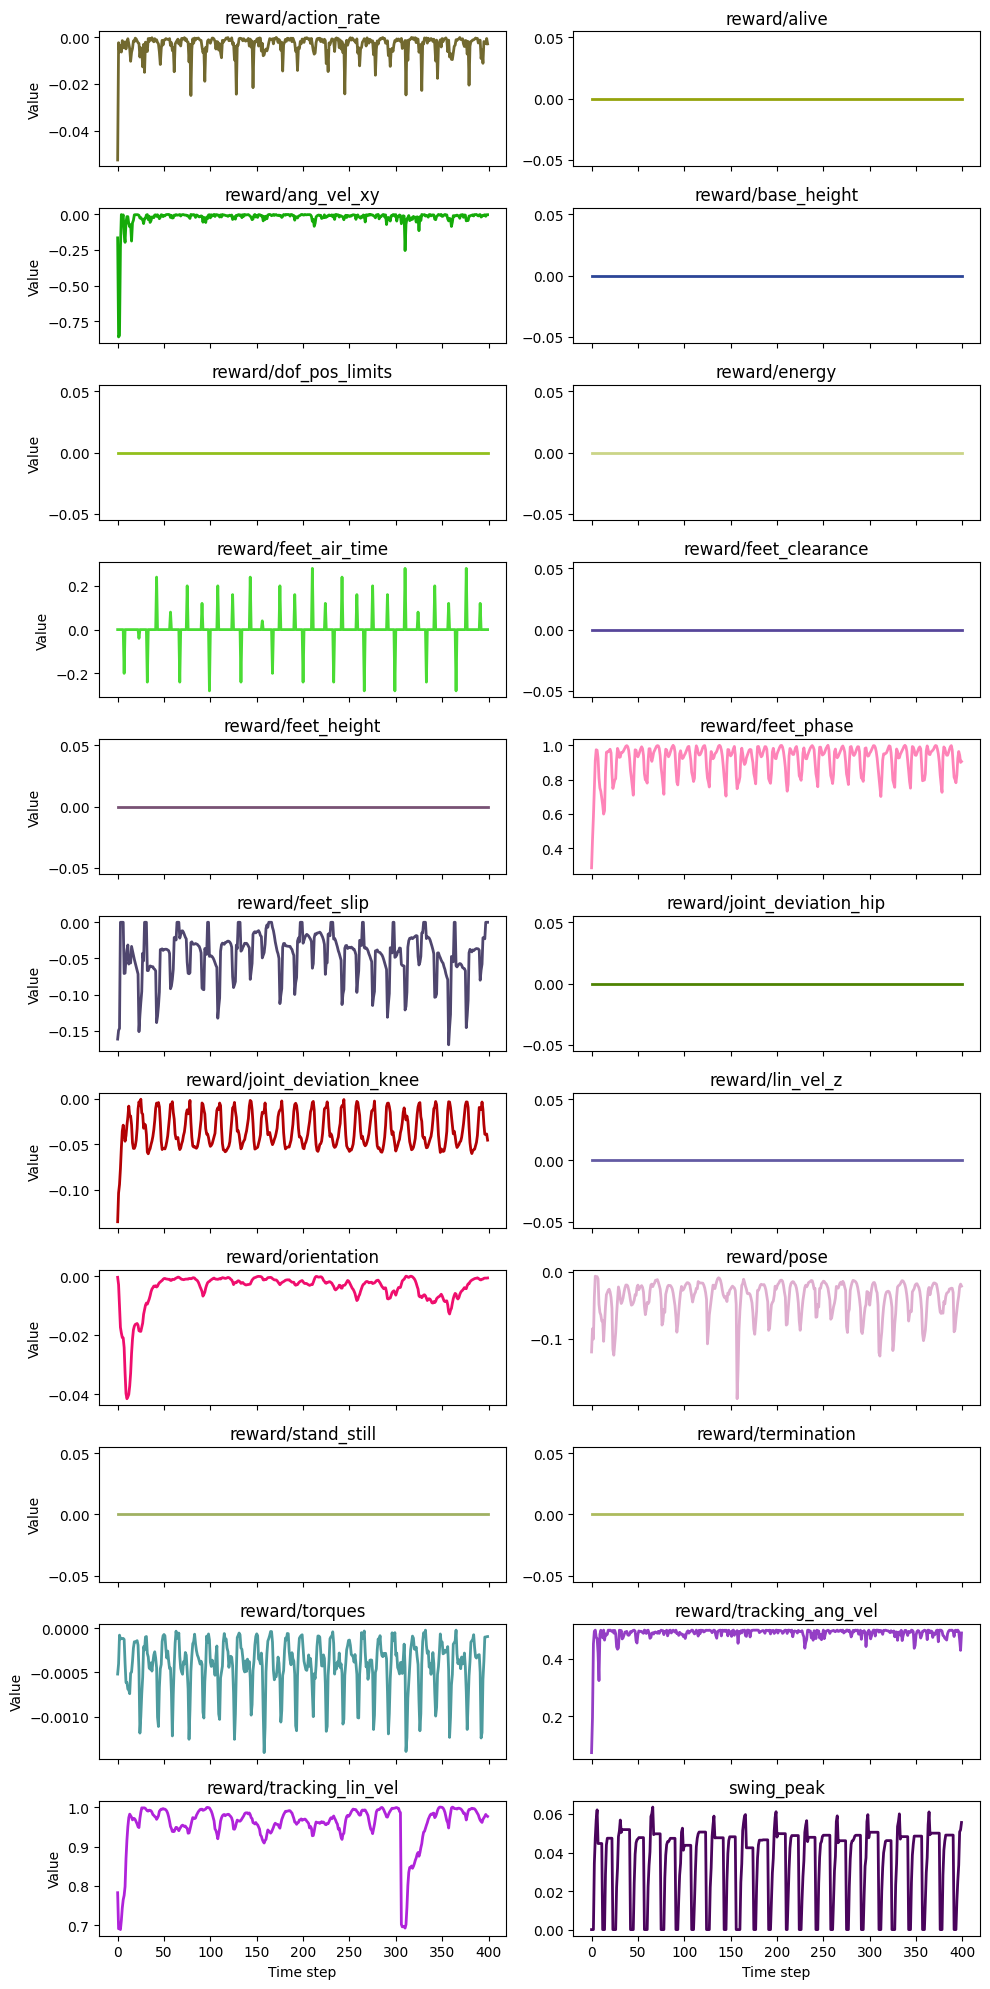

In [5]:
# Save to csv metrics
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(ABS_FOLDER_RESUlTS / 'metrics.csv')

df = pd.read_csv(ABS_FOLDER_RESUlTS / 'metrics.csv', index_col=0)
PLOT_METRIC = True
if PLOT_METRIC == True:
    fig, ax = plt.subplots(11, 2, figsize=(10, 20), sharex=True)
    # plt.suptitle('Metrics for the {} environment'.format(env_name))
    for i, col in enumerate(df.columns):
        random_color = np.random.rand(3,)
        ax[i//2, i%2].plot(df[col], color=random_color, linewidth=2)
        ax[i//2, i%2].set_title(col)
    for i in range(11):
        ax[i, 0].set_ylabel('Value')

    ax[10, 0].set_xlabel('Time step')
    ax[10, 1].set_xlabel('Time step')
    plt.tight_layout()
    fig.savefig(ABS_FOLDER_RESUlTS / 'metrics.png')
    # plt.show()


In [6]:
print(df['reward/base_height'])

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
395    0.0
396    0.0
397    0.0
398    0.0
399    0.0
Name: reward/base_height, Length: 400, dtype: float64


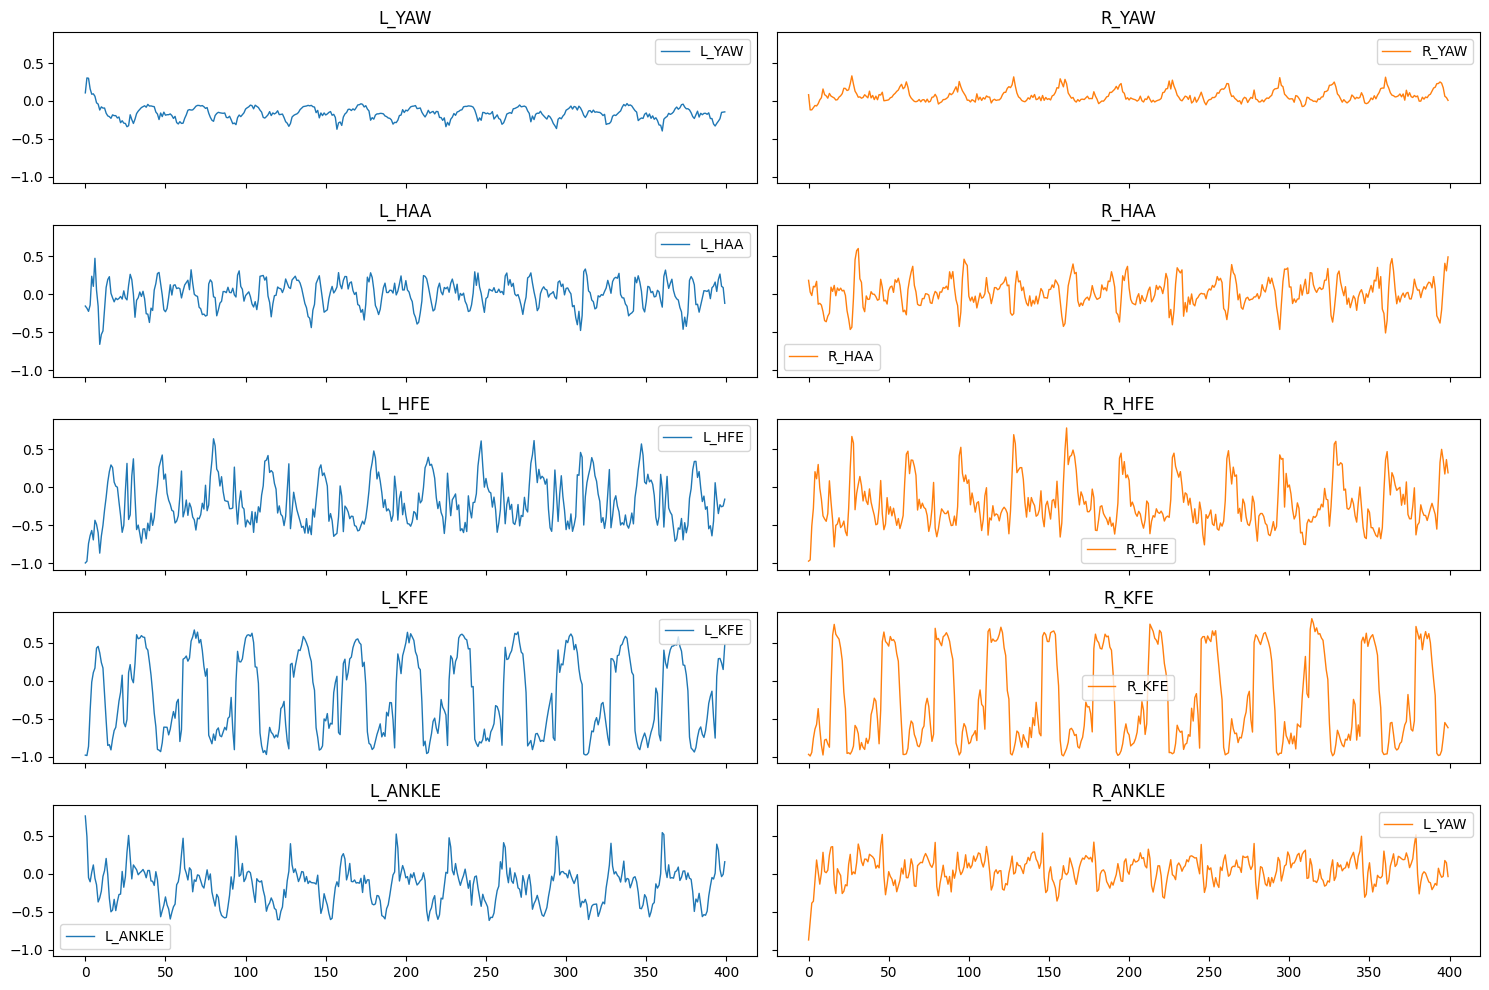

In [ ]:
ctrl_df = pd.DataFrame(ctrl_list)
ctrl_df.to_csv(ABS_FOLDER_RESUlTS / 'ctrl.csv')

col_names = ['L_YAW', 'L_HAA', 'L_HFE', 'L_KFE', 'L_ANKLE', 'R_YAW', 'R_HAA', 'R_HFE', 'R_KFE', 'R_ANKLE']
df = pd.read_csv(ABS_FOLDER_RESUlTS / 'ctrl.csv', names=col_names)

fig, ax = plt.subplots(5, 2, figsize=(15, 10), sharex=True, sharey=True)

# first half of the col names
for i in range(len(df.columns) // 2):
    ax[i, 0].plot(df[df.columns[i]], linewidth=1.0, label=df.columns[i], color='#1f77b4')
    ax[i, 0].set_title(df.columns[i])
    ax[i, 0].legend(loc='upper right')

# second half of the col names
for i in range(len(df.columns) // 2):
    ax[i, 1].plot(df[df.columns[i + len(df.columns) // 2]], linewidth=1.0, label=df.columns[i + len(df.columns) // 2], color='#ff7f0e')
    ax[i, 1].set_title(df.columns[i + len(df.columns) // 2])
    ax[i, 1].legend(loc='upper right')

plt.tight_layout()

plt.legend(df.columns, loc='upper right')
plt.savefig(ABS_FOLDER_RESUlTS / 'ctrl.png')
plt.show()